In [99]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, Flatten, LeakyReLU
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.lite as lt

Dataset yang digunakan: https://www.kaggle.com/preetviradiya/covid19-radiography-dataset

In [89]:
trainImageGenerator = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split = 0.2
)

validImageGenerator = ImageDataGenerator(
    rescale = 1.0 / 255,
    validation_split = 0.2
)

In [90]:
PATH = '../input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
trainGenerator = trainImageGenerator.flow_from_directory(
    directory = PATH,
    seed=666,
    subset = 'training',
    class_mode = 'categorical',
    target_size = [300, 300],
    batch_size = 256
)
validationGenerator = validImageGenerator.flow_from_directory(
    directory = PATH,
    seed=666,
    subset = 'validation',
    shuffle = False,
    class_mode = 'categorical',
    target_size = [300, 300],
    batch_size = 256  
)
NUM_CLASS = validationGenerator.num_classes
print(NUM_CLASS)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
4


In [91]:
def defineModel():
  # layer conv2d dan maxpooling terdapat dalam pretrained model VGG19
  base = VGG19(include_top=False, input_shape=(300, 300, 3))
#   base.trainable = False
  percentage = 5
  num = int(len(base.layers) / percentage) * (percentage - 1)
  for i in base.layers[num:-1]:
    i.trainable = True
  for i in base.layers[:num]:
    i.trainable = False
  base.summary()
  layers = [
            base,
            Flatten(),
            BatchNormalization(),
            Dense(128, activation=LeakyReLU(0.1)),
            Dropout(0.2),
            BatchNormalization(),
            Dense(256, activation=LeakyReLU(0.1)),
            Dropout(0.3),
            Dense(NUM_CLASS, activation='softmax')
  ]
  model = Sequential(layers=layers)
  model.compile(
      loss = 'categorical_crossentropy',
      optimizer = Nadam(learning_rate = 0.001),
      metrics = ['accuracy']
  )
  model.summary()
  return model
model = defineModel()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [92]:
CHECKPOINT = './checkpoints/checkpoint.ckpt'
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              mode = 'min', 
                              patience = 10
)
checkpoint = ModelCheckpoint(filepath = CHECKPOINT,
                             monitor = 'val_accuracy', 
                             save_weights_only=True, 
                             mode = 'max', 
                             save_best_only = True
)

plateu = ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.5)

history = model.fit(
    trainGenerator,
    steps_per_epoch = 16,
    epochs = 200,
    validation_data = validationGenerator,
    validation_steps = 8,
    callbacks = [earlyStopping, checkpoint, plateu],
    verbose = 1
)

Epoch 1/200
16/16 [==============================] - 37s 2s/step - loss: 1.2096 - accuracy: 0.5580 - val_loss: 34.6239 - val_accuracy: 0.1016
Epoch 2/200
16/16 [==============================] - 35s 2s/step - loss: 0.4120 - accuracy: 0.8531 - val_loss: 14.3913 - val_accuracy: 0.1436
Epoch 3/200
16/16 [==============================] - 35s 2s/step - loss: 0.3491 - accuracy: 0.8758 - val_loss: 2.8551 - val_accuracy: 0.6548
Epoch 4/200
16/16 [==============================] - 34s 2s/step - loss: 0.2738 - accuracy: 0.9069 - val_loss: 3.3875 - val_accuracy: 0.5029
Epoch 5/200
16/16 [==============================] - 35s 2s/step - loss: 0.2181 - accuracy: 0.9229 - val_loss: 0.9156 - val_accuracy: 0.7979
Epoch 6/200
16/16 [==============================] - 34s 2s/step - loss: 0.2000 - accuracy: 0.9258 - val_loss: 1.2025 - val_accuracy: 0.7173
Epoch 7/200
16/16 [==============================] - 35s 2s/step - loss: 0.1685 - accuracy: 0.9465 - val_loss: 0.6250 - val_accuracy: 0.8071
Epoch 8/200

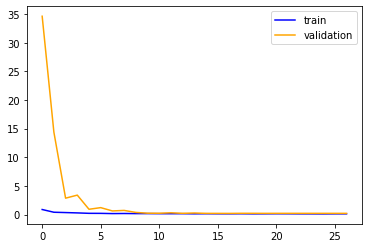

In [93]:
plt.plot(history.history['loss'], c='blue', label = 'train')
plt.plot(history.history['val_loss'], c = 'orange', label = 'validation')
plt.legend()
plt.show()

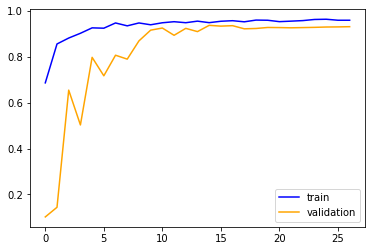

In [94]:
plt.plot(history.history['accuracy'], c='blue', label = 'train')
plt.plot(history.history['val_accuracy'], c = 'orange', label = 'validation')
plt.legend()
plt.show()

In [95]:
final_model = defineModel()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [96]:
final_model.load_weights(CHECKPOINT)
loss, acc = final_model.evaluate(validationGenerator)

17/17 [==============================] - 30s 2s/step - loss: 0.1959 - accuracy: 0.9396


In [97]:
print(loss, acc * 100)

0.18431618809700012 94.04537081718445


In [98]:
con = lt.TFLiteConverter.from_keras_model(final_model)
with open('./final_model.tflite', 'wb') as f:
  f.write(con.convert())